# Combining reinforcement learning and photonics

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

In [2]:
from tqdm import tqdm

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display  

## Creating a tuple type for storing experiences

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'next_state', 'action', 'reward')
)

## Function for normalizing state variables

In [5]:
def normalize_state(state):
    
    state[0] = state[0]/4.8
    state[2] = state[2]/0.418

## Class used for the implementation of the simulation of the photonics system

In [6]:
class NonLinearity:
    
    def __init__(self, num_nodes, delay=240e-9, tau_L=1/(12.5e9*2*np.pi), tau_H=1/(0.625e6*2*np.pi),
               beta=1, kappa=0.9, phi_0=-0.25*np.pi, deltat=1e-11):
    
        # Physical parameters
        self.params = [tau_L, tau_H, beta, kappa, phi_0]

        # Simulation parameters
        self.deltat = deltat
        self.ntau = int(np.floor(delay/deltat))
        
        self.num_nodes = num_nodes
        theta = delay/self.num_nodes
        self.step = int(np.floor(theta/deltat))
        
        # Initialise state vectors
        self.X = 0.01*np.random.normal(loc=0.0, scale=1.0, size=(self.ntau))
        self.Y = 0.01*np.random.normal(loc=0.0, scale=1.0, size=(self.ntau))   
    
    # simulating evolution of X variable
    def fnlx(self, x, y, u, xtau):
        
        tau_L = self.params[0]
        tau_H = self.params[1]
        beta = self.params[2]
        kappa = self.params[3]
        phi_0 = self.params[4]
        return -(1/tau_L+1/tau_H)*x - y/tau_L + beta/tau_L*(np.power(np.cos(kappa*xtau+np.pi/4*u+phi_0), 2))
    
    # simulating evolution of Y variable
    def fnly(self, x):
        
        tau_H = self.params[1]
        return 1/tau_H*x
    
    # solving differential equation with first order approximation
    def forward(self, Us):

        prev_X = np.roll(self.X, 1)
        prev_Y = np.roll(self.Y, 1)
        
        self.X = prev_X + self.deltat*self.fnlx(prev_X, prev_Y, Us, self.X)
        self.Y = prev_Y + self.deltat*self.fnly(prev_X)
        
        #for n in range(self.ntau):
            #self.X[n] = self.X[n-1] + self.deltat*self.fnlx(self.X[n-1], self.Y[n-1], Us[n], self.X[n])
            #self.Y[n] = self.Y[n-1] + self.deltat*self.fnly(self.X[n-1])
        
        idx = np.linspace(self.step-1, self.ntau-1, self.num_nodes, dtype=int)
        return self.X[idx]

## Class that implements the reservoir computing using photonics simulation

In [7]:
class ReservoirComputing:
    
    def __init__(self, num_states, num_nodes, num_actions, mu=0.6, b=0.8, lr=4e-4, gamma=0.995):
        
        self.M = np.random.uniform(low=-1.0, high=1.0, size=(num_states+1, num_nodes))
        self.mu = mu
        self.b = b
        self.gamma = gamma
        self.lr = lr
        self.nl = NonLinearity(num_nodes)  
        self.W = np.random.uniform(low=-0.1, high=0.1, size=(num_actions, num_nodes))
        
    
    # apply masking to obtained states
    def apply_mask(self, s):
        
        z = np.append(self.mu*s, self.b)
        u = np.transpose(np.matmul(z, self.M))
        return u
    
    # stretching the signal u temporaly
    def stretch_temporaly(self, u):
        
        step = self.nl.step
        us = np.repeat(u, step)
        return us
        
    # applying non-linearity (photonics simulation) to stretched signal
    def apply_nl(self, us): 
    
        v = self.nl.forward(us)
        return v
    
    # applying mask, strectching and applying non-linearity to siganl s
    def calculate_v(self, s):
        
        u = self.apply_mask(s)
        us = self.stretch_temporaly(u)
        v = self.apply_nl(us)
        return v
        
    # selecting action to be taken given updated matrix W
    def select_action(self, v):
    
        action_space = np.matmul(self.W, v)
        action = np.argmax(action_space)
        return action
    
    # Udating matrix W givn obtained new experiences
    def update_W(self, experience):
        state = experience[0]
        next_state = experience[1]
        action = experience[2]
        reward = experience[3]
        
        cur_v = self.calculate_v(state)
        next_v = self.calculate_v(next_state)
        
        loss = reward + self.gamma*np.max(np.matmul(self.W, next_v)) - np.dot(self.W[action,:], cur_v)
        self.W[action,:] = self.W[action,:] + self.lr*loss*cur_v

## Creating class that manages the cart pole environment (applies action chosen by Agent and collects state variables)

In [8]:
class CartPoleEnvManager:
    
    def __init__(self):
        self.env = gym.make('CartPole-v1').unwrapped
        self.env.reset()
        self.done = False
        self.total_reward = 0
        
    # Resets environment if episodes reaches its end
    def reset(self):
        self.env.reset()
        self.done = False
        self.total_reward = 0

    # Closes environment
    def close(self):
        self.env.close()

    # Shows the image of the cart pole environment
    def render(self, mode='human'):
        return self.env.render(mode)
    
    # Gets number of possible states to be in
    def num_states_available(self):
        return self.env.observation_space.shape[0]
    
    # Gets number of possible actions to be taken
    def num_actions_available(self):
        return self.env.action_space.n
    
    # Gets current state
    def get_state(self):
        return np.asarray(self.env.state)
    
    # Applies action chosen by the Agent
    def take_action(self, action):        
        state, reward, self.done, _ = self.env.step(action)
        self.total_reward = self.total_reward + reward
        return state, reward

## Creating a ReplayMemory for storing and managing the collected experiences

In [9]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Creating class for managing the Exploration - Exploitation bias (by using the Epsilon Greedy strategy)

In [10]:
class EpsilonGreedyStrategy:
    
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end)*np.exp(-current_step*self.decay)

## Creating class to implement the agent that decides which action is to be taken given the current state

In [11]:
class Agent:
    
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        
    def select_action(self, state, reservoir_computing):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions) # explore      
        else:
            v = reservoir_computing.calculate_v(state) 
            action = reservoir_computing.select_action(v) # exploit  
            
        return action

## Functions used to plot the moving average of the rewards obtained by the reinforcement learning algorithm

In [12]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(values, moving_avg_period)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values))
    print(moving_avg_period, "episodes moving average: ", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [13]:
def get_moving_average(values, period):

    if len(values) >= period:
        moving_avg = np.convolve(values, np.ones(period)/period, mode='valid')
    else:
        moving_avg = np.zeros(len(values))
        
    return moving_avg

## Setting up classes and parameters for reinforcement learning algorithm

In [14]:
# setting up cart pole manager
em = CartPoleEnvManager()

# setting up reservoir comuting
num_states = em.num_states_available()
num_actions = em.num_actions_available()
rc = ReservoirComputing(num_states, 600, num_actions)

# setting up Epsilon Greed strategy
eps_start = 1
eps_end = 0.01
eps_decay = 0.004
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

# setting up replay memory
memory_size = 4000
batch_size = 256
memory = ReplayMemory(memory_size)

# setting up agent
agent = Agent(strategy, num_actions)

## Running reinforcement learning algorithm

The longer the duration of the episode, the better the performance.

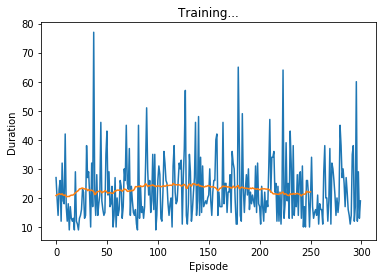

Episode 300
50 episodes moving average:  22.12


In [15]:
num_episodes = 300
mov_avg_per = 50
rewards = []
for episode in range(num_episodes):
    
    em.reset()
    state = em.get_state()
    normalize_state(state)
    
    while em.done == False:
        
        action = agent.select_action(state, rc) # selecting action to be taken
        next_state, reward = em.take_action(action) # taking action and collecting next state and reward
        normalize_state(next_state) # normalizing next state
        memory.push(Experience(state, next_state, action, reward)) # storing experience at the replay memory
        state = next_state
        
        if memory.can_provide_sample(batch_size): # if replay memory has, at least, batch_size (256) memories
            experiences = memory.sample(batch_size) # random samples batch_size (256) memories from replay memory
            
            # updating reservoir computing given experiences
            for experience in experiences:
                rc.update_W(experience)
            
        if em.done: # if episode is finished
            rewards.append(em.total_reward)
            plot(rewards, mov_avg_per)
            break
                    
em.close()

## Playing one episode of the cart pole environment (after training)

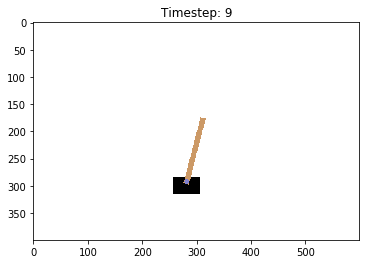

Done!


In [16]:
em.reset()
state = em.get_state()

for timestep in count():

    v = rc.calculate_v(state) 
    action = rc.select_action(v) 
    _ = em.take_action(action)
    state = em.get_state()
    screen = em.render("rgb_array")

    plt.imshow(screen)
    plt.title("Timestep: " + str(timestep))
    plt.show()
    plt.pause(1e-4)
    
    if em.done:
        print("Done!")
        break
        
    if is_ipython: display.clear_output(wait=True)